In [2]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [3]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/train_0irEZ2H.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/test_nfaJ3J5.csv')

train = data1.copy()
test = data2.copy()

train.shape, test.shape

((150150, 9), (13860, 8))

In [5]:
train.sample(10)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
112189,158856,27/11/12,8218,245338,396.1500,469.5375,1,0,27
68056,96328,27/02/12,9881,217390,163.8750,163.8750,0,0,88
107833,152678,30/10/12,9147,223245,227.2875,227.2875,0,0,42
68739,97290,06/03/12,9430,216425,119.7000,119.7000,0,0,31
71176,100738,20/03/12,9498,216418,68.4000,86.2125,0,0,27
27760,39296,04/07/11,8094,320485,205.9125,205.9125,0,0,27
7095,10048,28/02/11,8317,378934,177.4125,177.4125,0,0,77
41943,59320,26/09/11,9092,216425,123.2625,123.2625,0,0,12
114160,161670,04/12/12,9809,216425,118.9875,118.9875,0,0,21
44837,63401,10/10/11,9823,245387,321.3375,498.0375,0,1,89


In [4]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

num.columns, cat.columns

(Index(['record_ID', 'store_id', 'sku_id', 'total_price', 'base_price',
        'is_featured_sku', 'is_display_sku', 'units_sold'],
       dtype='object'),
 Index(['week'], dtype='object'))

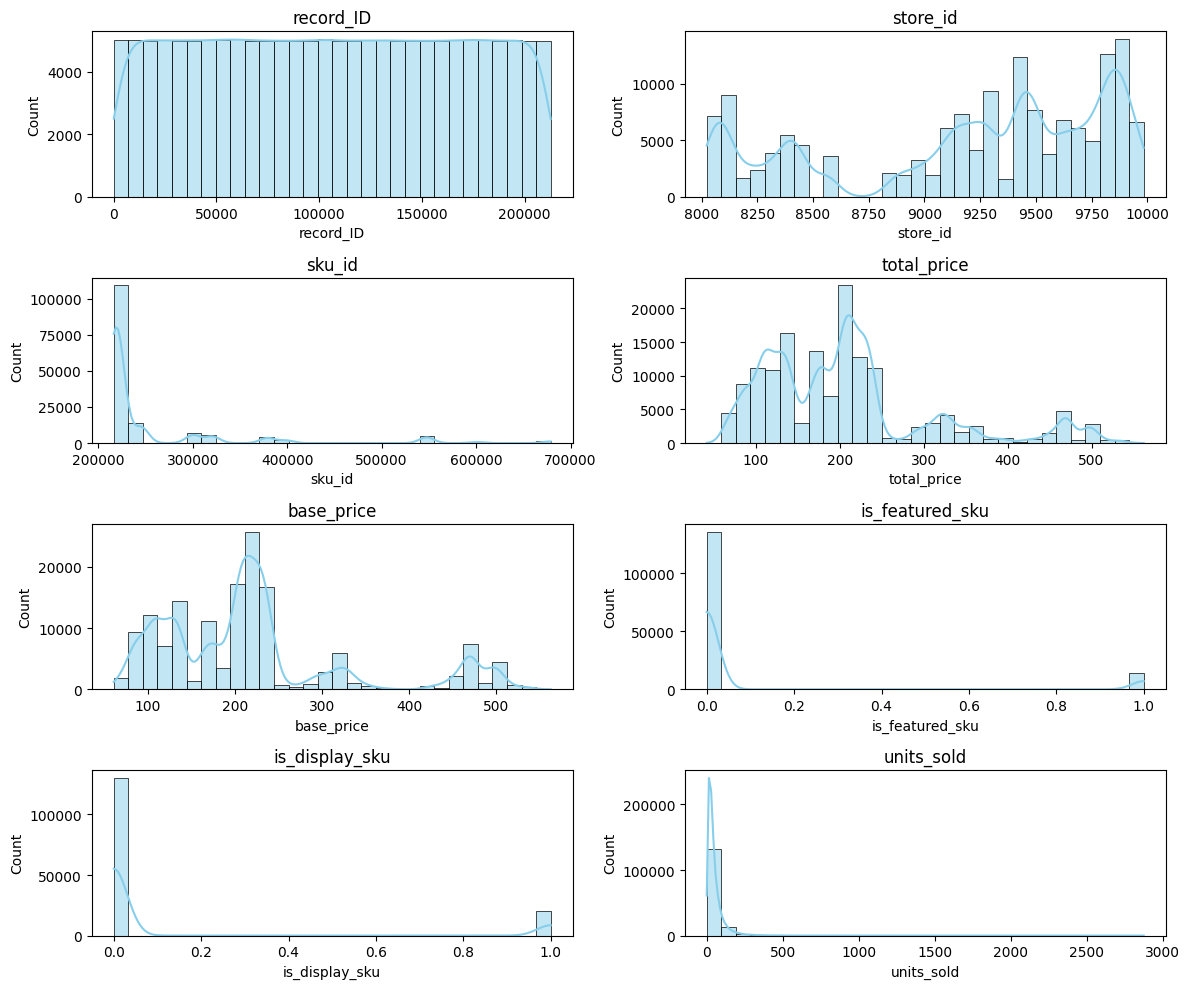

In [6]:
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(4, 2, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [12]:
#visualizing the average sales for featured and displayed SKUs

featured_skus = train.groupby('is_featured_sku')['units_sold'].mean()

featured_skus

is_featured_sku
0     45.062330
1    114.216216
Name: units_sold, dtype: float64

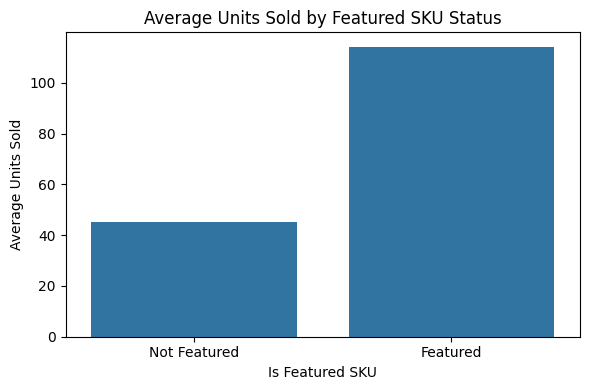

In [14]:
featured_skus_df = featured_skus.reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='is_featured_sku', y='units_sold', data=featured_skus_df)

plt.title('Average Units Sold by Featured SKU Status')
plt.xlabel('Is Featured SKU')
plt.ylabel('Average Units Sold')
plt.xticks([0, 1], ['Not Featured', 'Featured'])
plt.tight_layout()
plt.show()

In [13]:
displayed_skus = train.groupby('is_display_sku')['units_sold'].mean()

displayed_skus

is_display_sku
0     43.114721
1    107.375050
Name: units_sold, dtype: float64

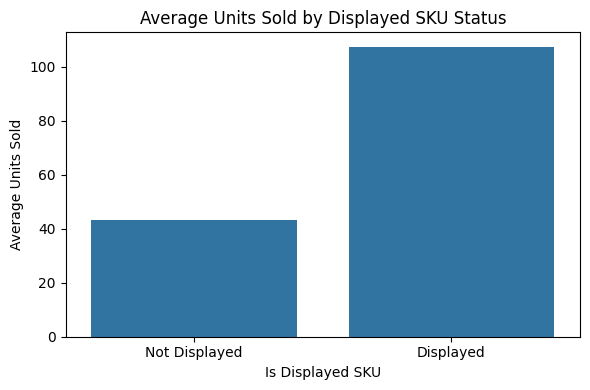

In [15]:
displayed_skus_df = displayed_skus.reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='is_display_sku', y='units_sold', data=displayed_skus_df)

plt.title('Average Units Sold by Displayed SKU Status')
plt.xlabel('Is Displayed SKU')
plt.ylabel('Average Units Sold')
plt.xticks([0, 1], ['Not Displayed', 'Displayed'])
plt.tight_layout()
plt.show()

# Feature engineering

In [ ]:
train['price_diff'] = train['base_price'] - train['total_price']
test['price_diff'] = test['base_price'] - test['total_price']

train['discount_applied'] = (train['price_diff'] / 100.0) * train['base_price']
test['discount_applied'] = (test['price_diff'] / 100.0) * test['base_price']

train['store_sku_id'] = str(train['store_id']) + '_' + str(train['sku_id'])
test['store_sku_id'] = str(test['store_id']) + '_' + str(test['sku_id'])

print('First 3 rows of Train after feature engineering: \n', train.head(3))
print('First 3 rows of Test after feature engineering: \n', test.head(3))



First 3 rows of Train after feature engineering: 
    record_ID      week  store_id  sku_id  total_price  base_price  \
0          1  17/01/11      8091  216418      99.0375    111.8625   
1          2  17/01/11      8091  216419      99.0375     99.0375   
2          3  17/01/11      8091  216425     133.9500    133.9500   

   is_featured_sku  is_display_sku  units_sold  price_diff  discount_applied  \
0                0               0          20      12.825         14.346366   
1                0               0          28       0.000          0.000000   
2                0               0          19       0.000          0.000000   

                                                                                                                                                                                                                                                                                                                                                               

In [18]:
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))
train = train.drop(columns='store_sku_id')
test = test.drop(columns='store_sku_id')

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   record_ID         150150 non-null  int64  
 1   week              150150 non-null  object 
 2   store_id          150150 non-null  int64  
 3   sku_id            150150 non-null  int64  
 4   total_price       150149 non-null  float64
 5   base_price        150150 non-null  float64
 6   is_featured_sku   150150 non-null  int64  
 7   is_display_sku    150150 non-null  int64  
 8   units_sold        150150 non-null  int64  
 9   price_diff        150149 non-null  float64
 10  discount_applied  150149 non-null  float64
 11  store_sku         150150 non-null  object 
dtypes: float64(4), int64(6), object(2)
memory usage: 13.7+ MB


In [22]:
#datetime feature engineering

import datetime

train['week'] = pd.to_datetime(train['week'])
test['week'] = pd.to_datetime(test['week'])

train['year'] = train['week'].dt.year
test['year'] = test['week'].dt.year
train['month'] = train['week'].dt.month
test['month'] = test['week'].dt.month
train['weekday'] = train['week'].dt.day_of_week
test['weekday'] = test['week'].dt.day_of_week
train['week_of_year'] = train['week'].dt.isocalendar().week
test['week_of_year'] = test['week'].dt.isocalendar().week


In [25]:
days_map = {
    0 : 1,
    1 : 2,
    2 : 3,
    3 : 4,
    4 : 5,
    5 : 6,
    6 : 7
}

train['weekday'] = train['weekday'].map(days_map)
test['weekday'] = test['weekday'].map(days_map)

train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,store_sku,year,month,weekday,week_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,8091_216418,2011,1,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,8091_216419,2011,1,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,8091_216425,2011,1,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,8091_216233,2011,1,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,8091_217390,2011,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,9984_223245,2013,9,6,36
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,9984_223153,2013,9,6,36
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,9984_245338,2013,9,6,36
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,9984_547934,2013,9,6,36


In [26]:
train = train.rename(columns={'week' : 'date'})
test = test.rename(columns={'week' : 'date'})

train

,record_ID,date,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,store_sku,year,month,weekday,week_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,8091_216418,2011,1,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,8091_216419,2011,1,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,8091_216425,2011,1,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,8091_216233,2011,1,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,8091_217390,2011,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,9984_223245,2013,9,6,36
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,9984_223153,2013,9,6,36
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,9984_245338,2013,9,6,36
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,9984_547934,2013,9,6,36


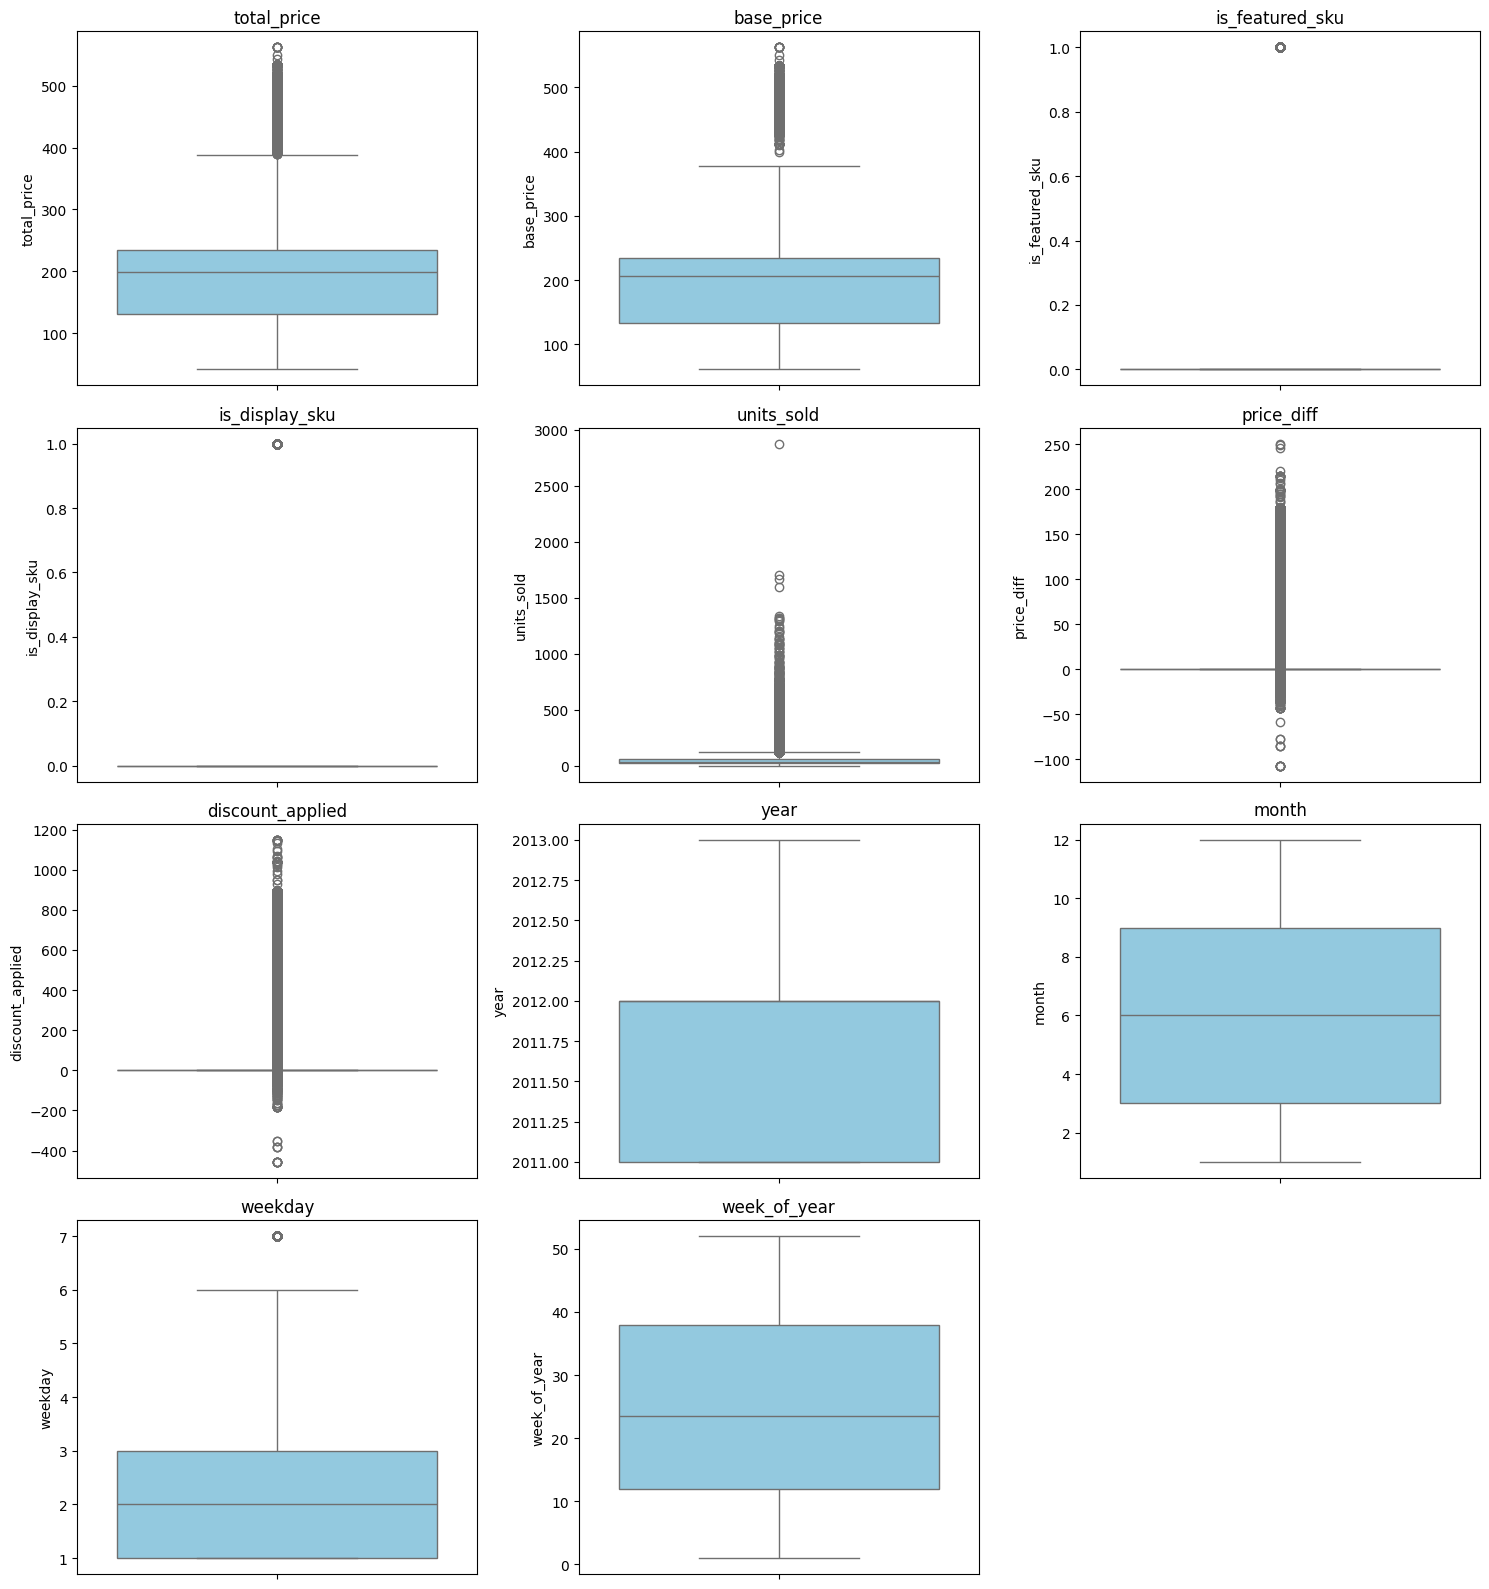

In [28]:
boxplot_cols = [
    'total_price', 'base_price', 'is_featured_sku', 'is_display_sku',
    'units_sold', 'price_diff', 'discount_applied', 'year',
    'month', 'weekday', 'week_of_year'
]

n_cols = 3
n_rows = (len(boxplot_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=train[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.show()

In [31]:
train.shape

(150150, 16)

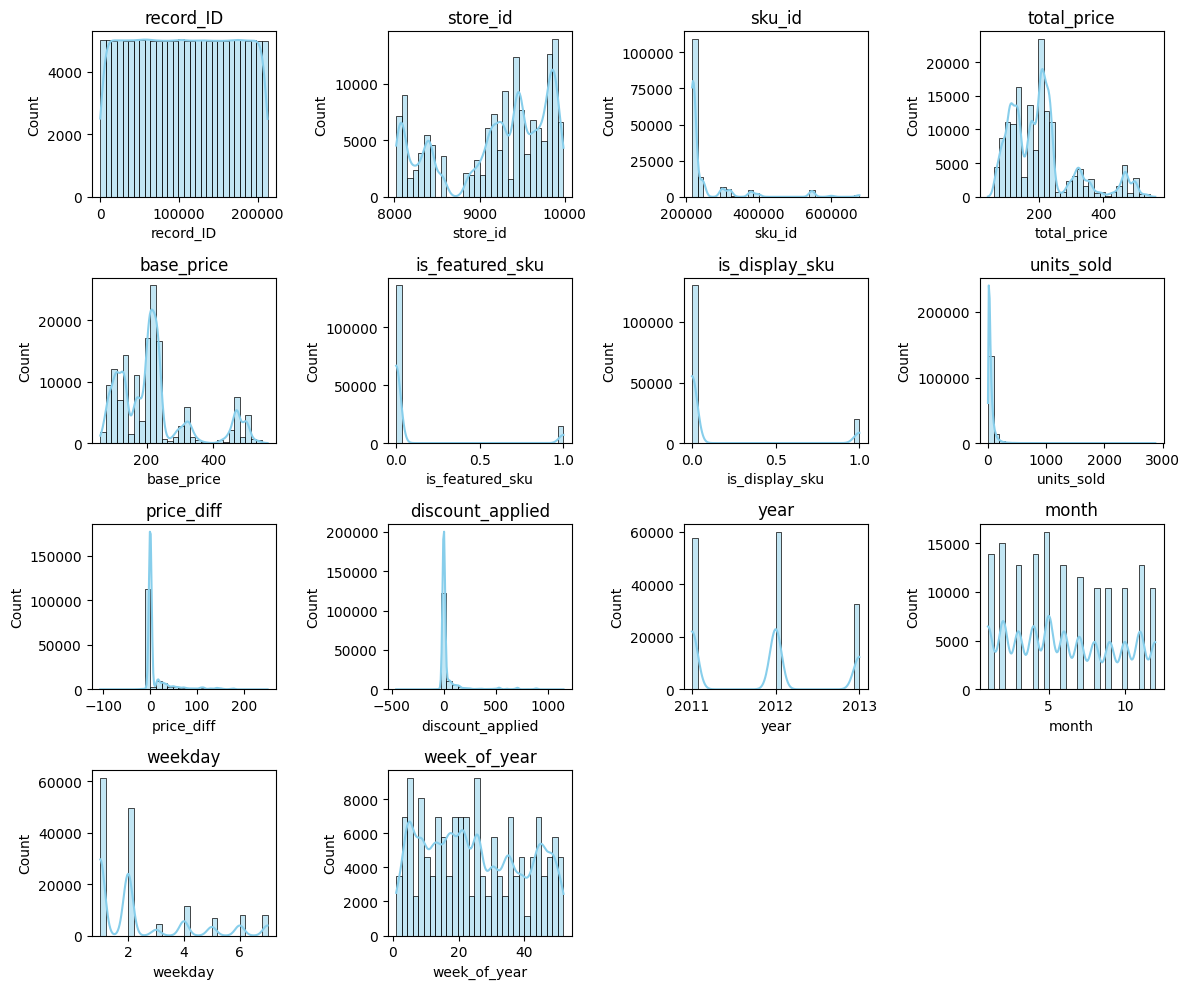

In [32]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [35]:
train['units_sold_log'] = np.log(train['units_sold'] + 1)

train['total_price_log'] = np.log(train['total_price'] + 1)
test['total_price_log'] = np.log(test['total_price'] + 1)

train['base_price_log'] = np.log(train['base_price'] + 1)
test['base_price_log'] = np.log(test['base_price'] + 1)

train['price_diff_log'] = np.log(train['price_diff'] + 1)
test['price_diff_log'] = np.log(test['price_diff'] + 1)

train['discount_applied_log'] = np.log(train['discount_applied'] + 1)
test['discount_applied_log'] = np.log(test['discount_applied'] + 1)

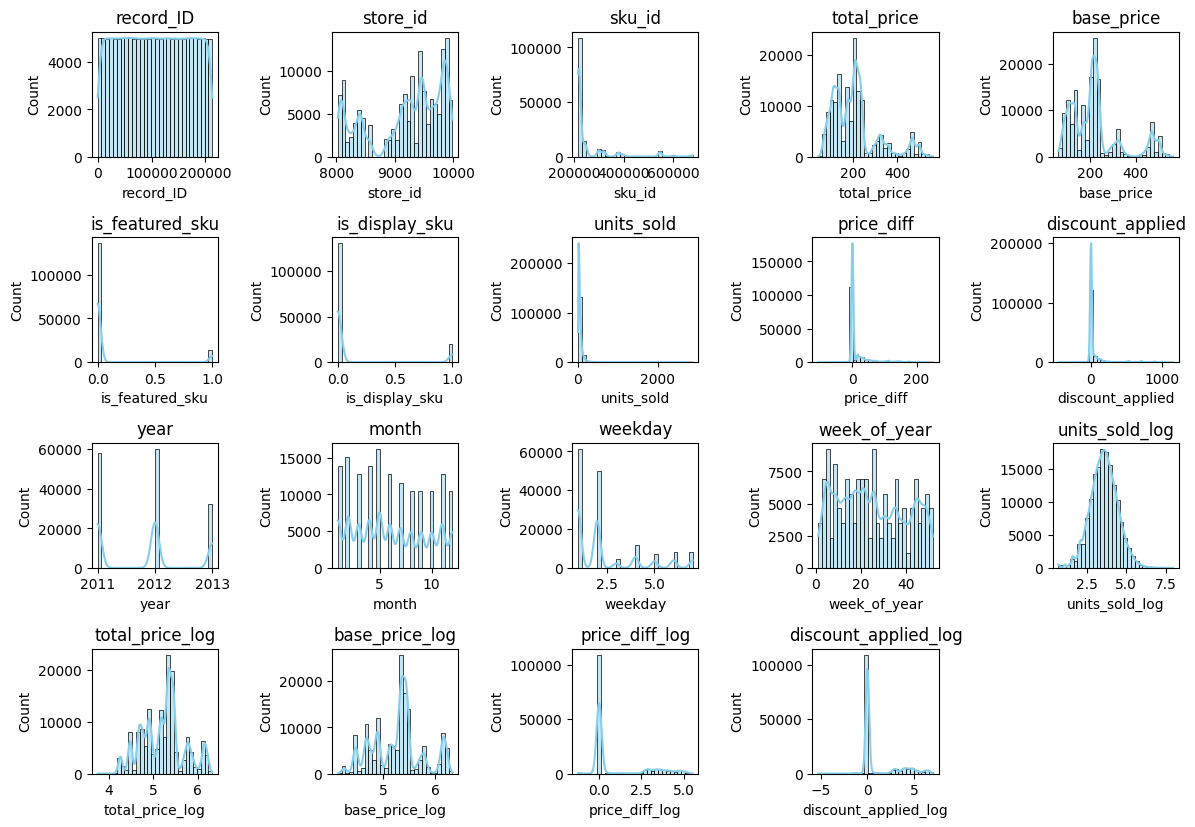

In [37]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(5, 5, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [38]:
from sklearn.preprocessing import PowerTransformer

cols_to_transform = ['price_diff', 'discount_applied']

pt = PowerTransformer(method='yeo-johnson')

transformed_train = pt.fit_transform(train[cols_to_transform])

transformed_test = pt.fit_transform(test[cols_to_transform])


for i, col in enumerate(cols_to_transform):
    train[f'{col}_yj'] = transformed_train[:, i]
    test[f'{col}_yj'] = transformed_test[:, i]

print(train, test)


        record_ID       date  store_id  sku_id  total_price  base_price  \
0               1 2011-01-17      8091  216418      99.0375    111.8625   
1               2 2011-01-17      8091  216419      99.0375     99.0375   
2               3 2011-01-17      8091  216425     133.9500    133.9500   
3               4 2011-01-17      8091  216233     133.9500    133.9500   
4               5 2011-01-17      8091  217390     141.0750    141.0750   
...           ...        ...       ...     ...          ...         ...   
150145     212638 2013-09-07      9984  223245     235.8375    235.8375   
150146     212639 2013-09-07      9984  223153     235.8375    235.8375   
150147     212642 2013-09-07      9984  245338     357.6750    483.7875   
150148     212643 2013-09-07      9984  547934     141.7875    191.6625   
150149     212644 2013-09-07      9984  679023     234.4125    234.4125   

        is_featured_sku  is_display_sku  units_sold  price_diff  ...  month  \
0                   

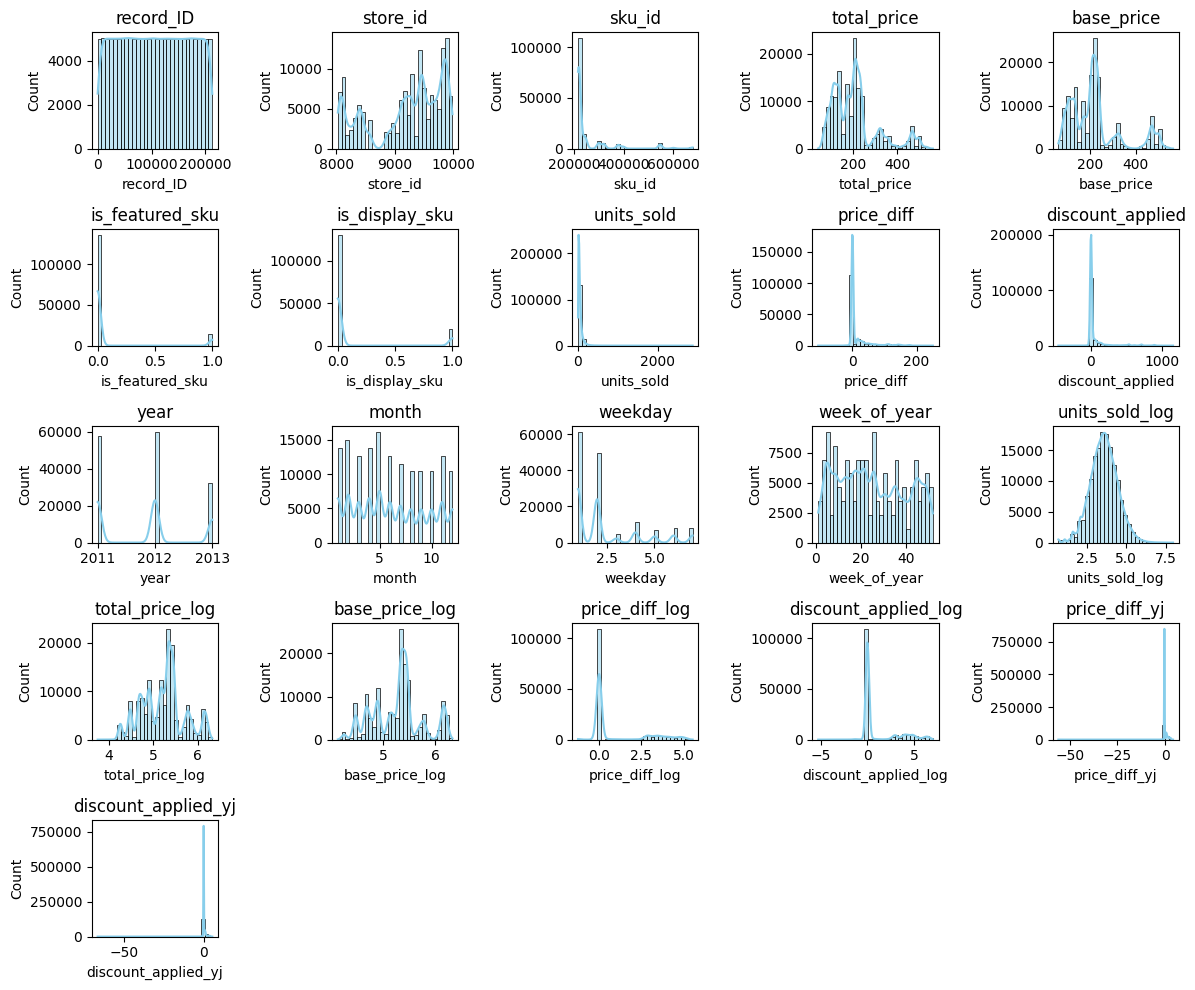

In [39]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(5, 5, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [40]:
train[['price_diff_yj', 'discount_applied_yj']].skew()

price_diff_yj         -10.447964
discount_applied_yj   -17.482093
dtype: float64

Too much left skew and it might hurt model performance. Different approach required to normalize the distribution.

In [41]:
train['price_diff_cbrt'] = np.cbrt(train['price_diff'])
train['discount_applied_cbrt'] = np.cbrt(train['discount_applied'])

test['price_diff_cbrt'] = np.cbrt(test['price_diff'])
test['discount_applied_cbrt'] = np.cbrt(test['discount_applied'])

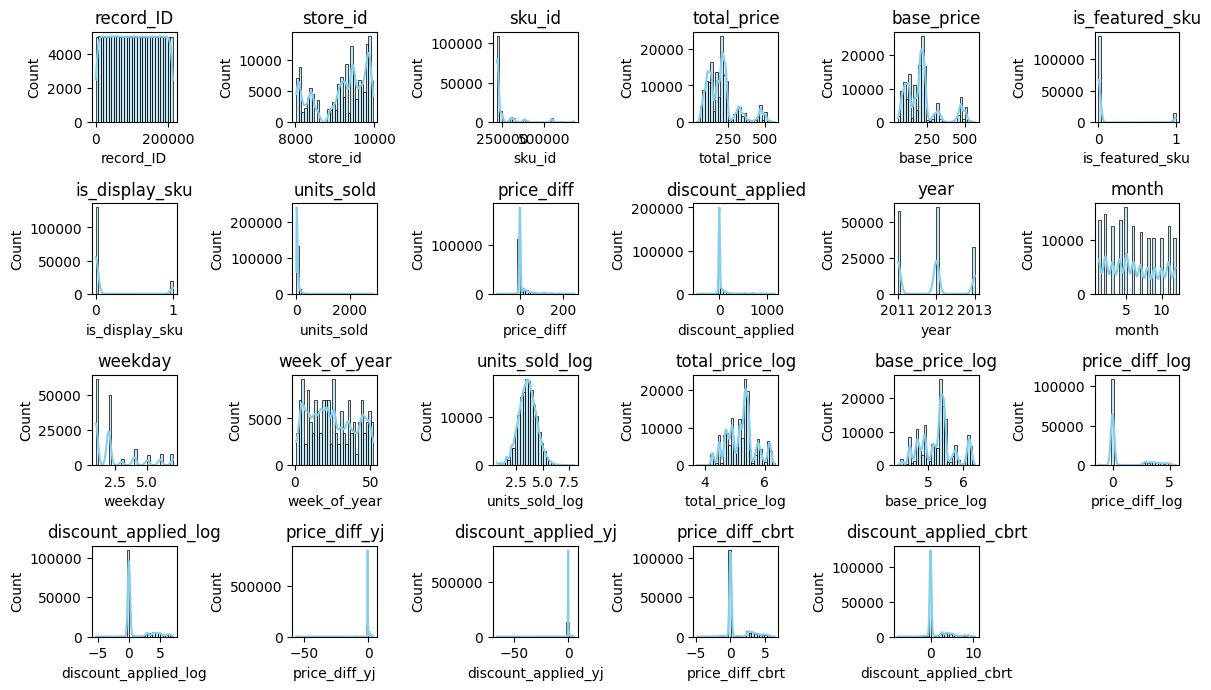

In [42]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(6, 6, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [43]:
train[['price_diff_cbrt', 'discount_applied_cbrt']].skew()

price_diff_cbrt          1.409143
discount_applied_cbrt    1.850051
dtype: float64